In [ ]:
# visualising the result of applying filters
# to input
# i.e. visualising feature maps
# tutorial: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/

In [2]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import skimage.io, scipy.ndimage, scipy.interpolate, scipy.signal, scipy.io.wavfile
import skimage.morphology, skimage.transform, skimage.feature, scipy.stats

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18.0, 10.0)

#standard utilities
def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)
    
def apply_color(img, fn):
    return np.dstack((fn(img[:,:,0]),fn(img[:,:,1]),fn(img[:,:,2])))

def load_and_normalise(fname):
    return skimage.io.imread(fname) / 256.0

def load_gray(f):
    return skimage.color.rgb2gray(load_and_normalise(f))

In [3]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import matplotlib.pyplot as plt
%matplotlib inline

import os
import numpy as np
from skimage.io import imread
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

folder = '/Users/Leonore/Documents/Workspace/l4proj/data/raw'

filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

image_width = 128
image_height = 128

dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)

i = 0
for file in filenames:
    try:
        image = imread(file)
        image_resized = resize(image, (image_width, image_height), anti_aliasing=False)
        dataset[i] = image_resized
    except Exception as e:
        print(e)
        print("{} is causing issues".format(file))
    i += 1

Could not find a format to read the specified file in mode 'i'
/Users/Leonore/Documents/Workspace/l4proj/data/raw/.DS_Store is causing issues


In [4]:
from sklearn.model_selection import train_test_split

# splitting and discarding labels as we don't need them
x_train, x_test, _, _ = train_test_split(dataset, dataset, test_size=0.2, random_state=11)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

x_train.shape

(471, 128, 128, 1)

In [15]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
filter_copy = x
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

In [35]:
model = Model(input_img, decoded)

In [21]:
model.layers[1]

In [17]:
filters, biases = model.layers[1].get_weights()

In [18]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

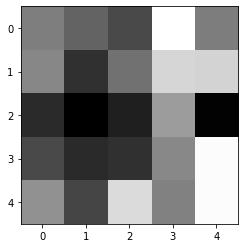

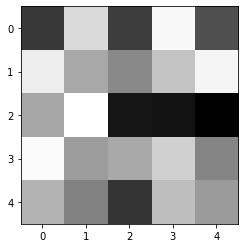

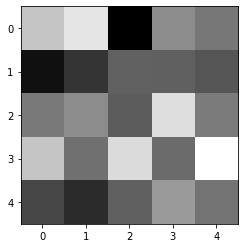

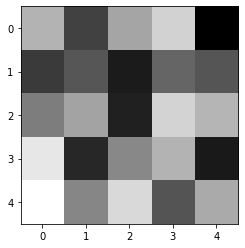

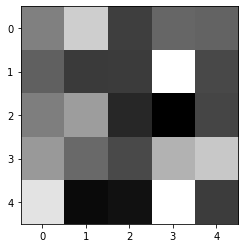

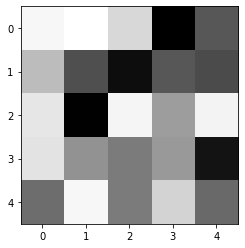

In [19]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    plt.figure()
    plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [22]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

1 conv2d_8 (?, 128, 128, 16)
3 conv2d_9 (?, 64, 64, 8)
5 conv2d_10 (?, 32, 32, 8)
7 conv2d_11 (?, 16, 16, 8)
9 conv2d_12 (?, 32, 32, 8)
11 conv2d_13 (?, 64, 64, 16)
13 conv2d_14 (?, 128, 128, 1)


In [23]:
# redefine model to output right after the first hidden layer
model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [24]:
x_train[11].shape

(128, 128, 1)

In [26]:
sample = np.expand_dims(x_train[11], axis=0)

In [27]:
sample.shape

(1, 128, 128, 1)

In [29]:
feature_maps = model.predict(sample)

In [31]:
feature_maps.shape

(1, 128, 128, 16)

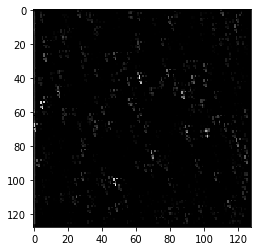

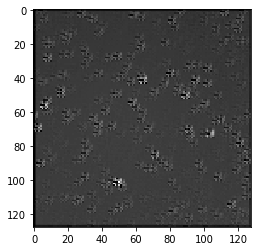

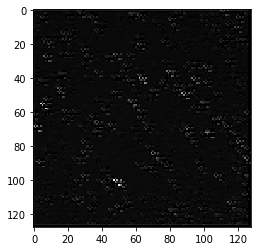

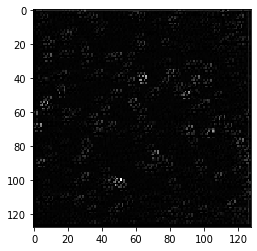

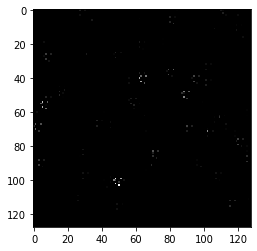

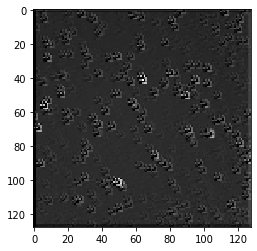

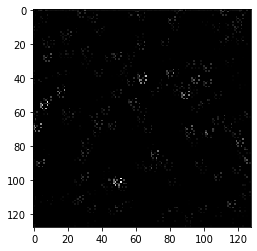

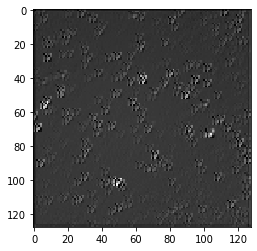

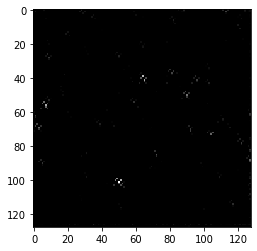

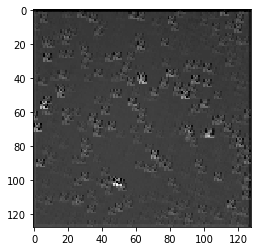

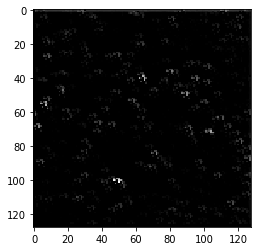

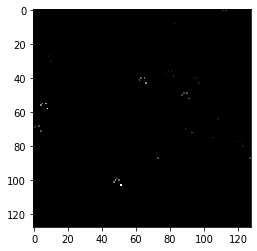

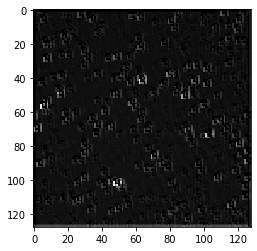

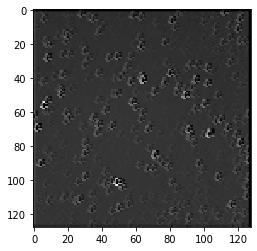

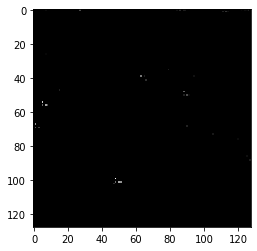

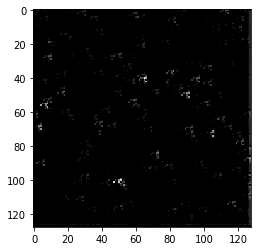

In [34]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  after removing the cwd from sys.path.


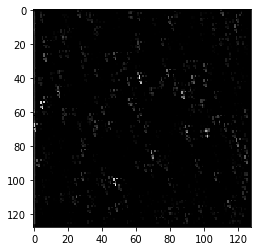

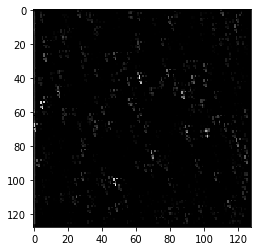

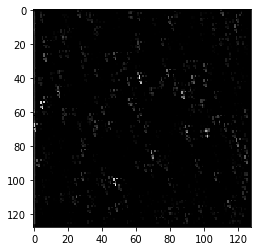

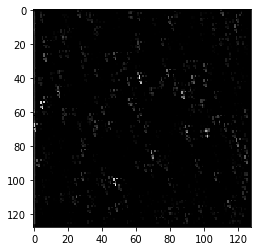

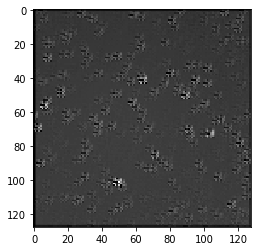

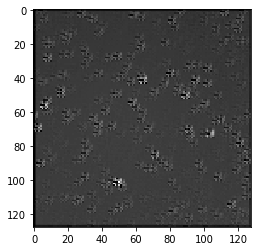

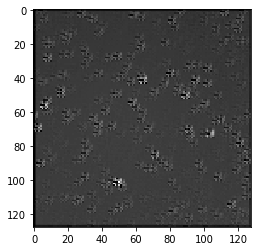

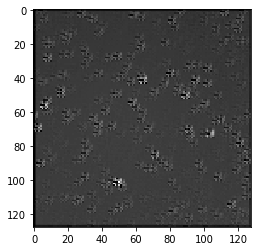

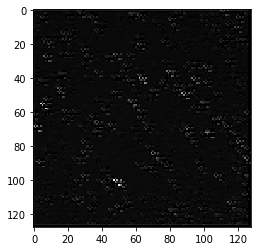

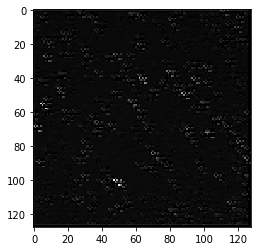

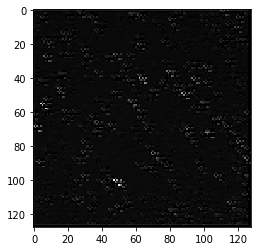

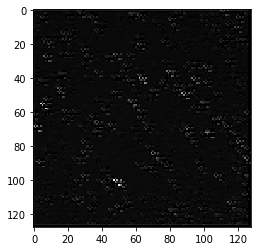

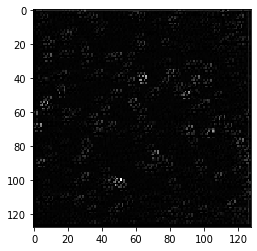

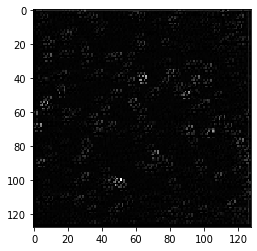

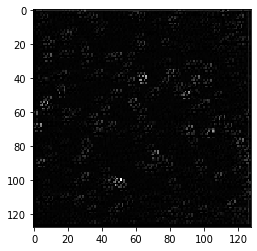

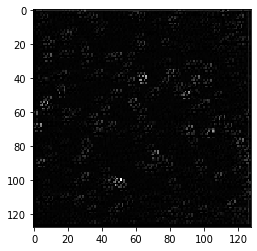

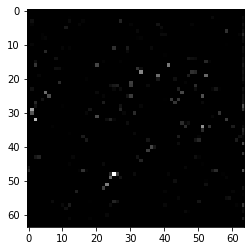

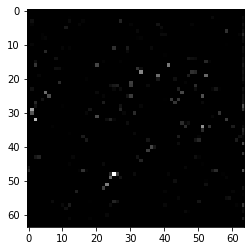

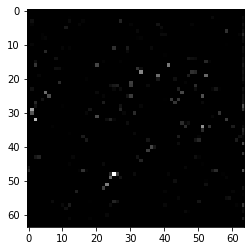

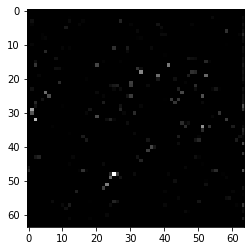

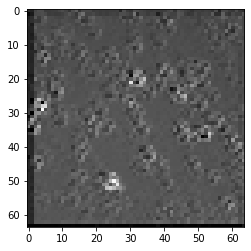

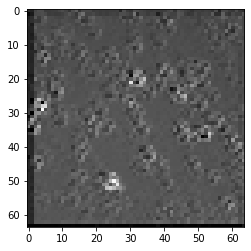

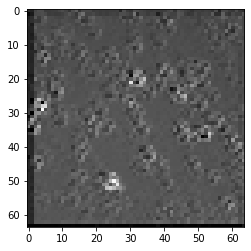

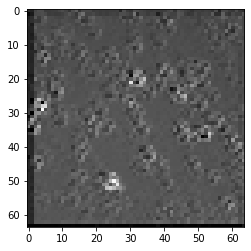

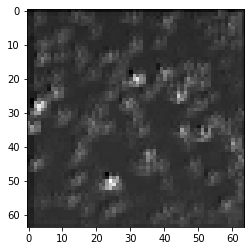

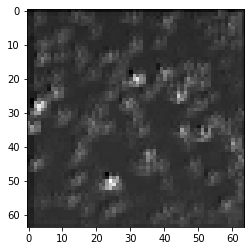

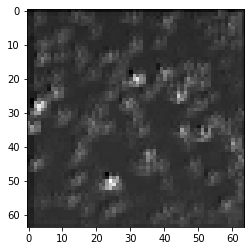

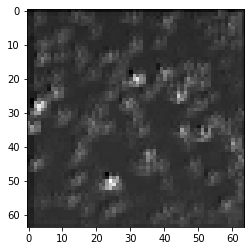

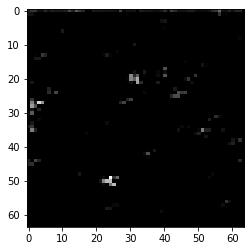

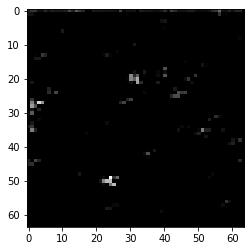

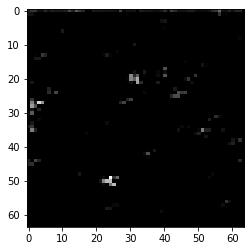

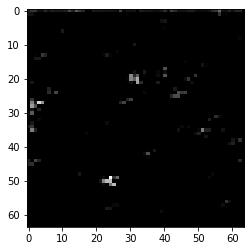

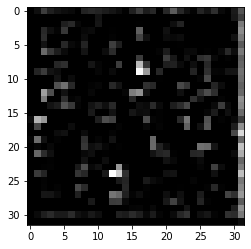

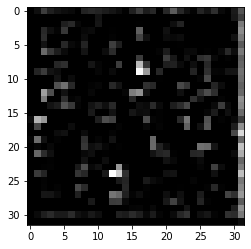

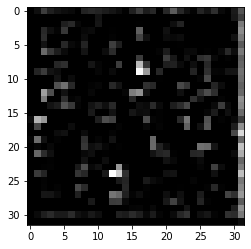

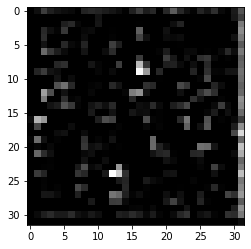

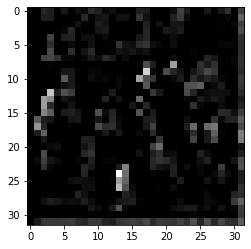

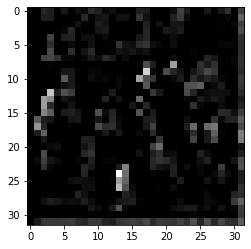

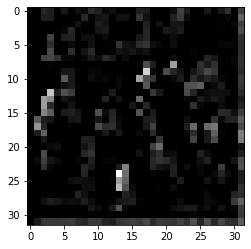

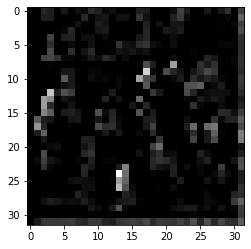

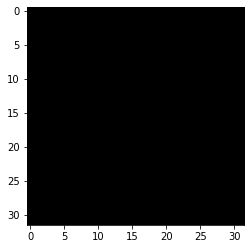

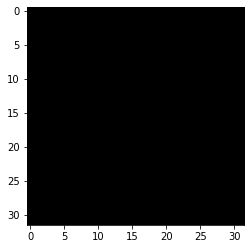

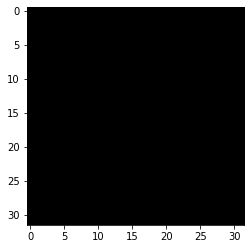

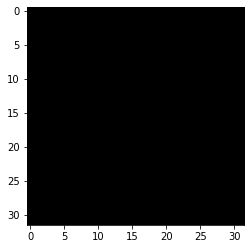

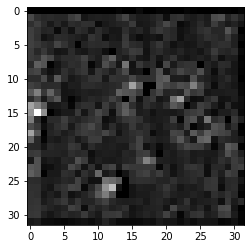

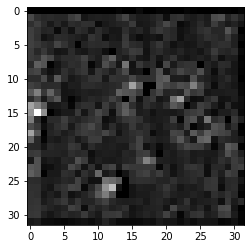

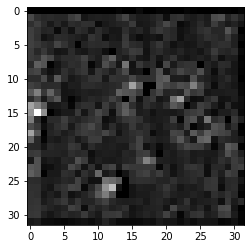

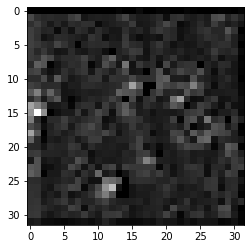

In [38]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()